In [1]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

#spectra imports 
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets

In [2]:
obs_key = 'cell_type_annotations'

In [16]:
# adata = spc.sample_data.load()
# adata

adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slideseq/day3_1.h5ad')
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [17]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [19]:
adata.obs['rctd_cluster'] = adata.obs['rctd_cluster'].cat.rename_categories({
    0: "B_naive",
    1: "CD8_T",
    2: "Th2",
    3: "Resting T-cell",
    4: "CD4_T",
    5: "Treg",
    6: "NK"
})

In [20]:
adata.obs['cell_type_annotations'] = adata.obs['rctd_cluster']

In [44]:
annotations = spc.default_gene_sets.load()

In [49]:
annotations.keys()

dict_keys(['B_GC', 'B_memory', 'B_naive', 'CD4_T', 'CD8_T', 'DC', 'ILC3', 'MDC', 'NK', 'Treg', 'gdT', 'mast', 'pDC', 'plasma', 'global'])

In [53]:
annotations['CD4_T'].keys()

dict_keys(['CD4-T_IL12_response', 'TNK_IL2_response', 'CD4-T_TH22_UP', 'CD4-T_TH17_UP', 'TNK_IL2-STAT5-signaling', 'T_IL21_response', 'CD4-T_TH9_UP', 'CD4-T_TFH_UP', 'CD4-T_IL4_response', 'CD4-T_TH2_UP', 'CD4-T_TH1_UP'])

In [22]:
def format_gene_name(gene):
    if gene and isinstance(gene, str):
        return gene[0] + gene[1:].lower()
    return gene

def transform_annotations(ann):
    if isinstance(ann, dict):
        new_ann = {}
        for key, value in ann.items():
            if isinstance(value, dict):
                new_ann[key] = transform_annotations(value)
            elif isinstance(value, list):
                new_ann[key] = [format_gene_name(g) for g in value]
            else:
                new_ann[key] = value
        return new_ann
    elif isinstance(ann, list):
        return [transform_annotations(item) for item in ann]
    else:
        return ann

annotations = transform_annotations(annotations)
annotations

{'B_GC': {},
 'B_memory': {'B_Breg_UP': ['Tgfb1', 'Il10', 'Il12a', 'Ebi3', 'Tgfb2'],
  'B_effector-2_UP': ['Il2', 'Il13', 'Il4', 'Csf2', 'Il6', 'Il10'],
  'B_effector-1_UP': ['Il12b',
   'Ifng',
   'Tnf',
   'Itgal',
   'Il12a',
   'Il10',
   'Timd4',
   'Fcgr3a',
   'Il6'],
  'B_IgM-ligation_response': ['Incenp',
   'Dcbld2',
   'Ap1s2',
   'Lig1',
   'Aurkb',
   'Clic4',
   'Stk33',
   'Aurka',
   'Btla',
   'Ndc80',
   'Wdhd1',
   'Cdc25c',
   'Cpox',
   'Kif15',
   'Nfkb1',
   'Kif4a',
   'Stmn1',
   'Atad5',
   'Cenpn',
   'Eif3c',
   'Racgap1',
   'Sgo1',
   'Cbx5',
   'Tipin',
   'Cdk1',
   'Tifab',
   'Ttk',
   'Ncapg',
   'Atp11c',
   'Spc25',
   'Gzmk',
   'Aspm',
   'Hells',
   'Mis18bp1',
   'Ect2',
   'Apobec2',
   'Cenpe',
   'Sgo2',
   'Hmmr',
   'Prr11',
   'Plk1',
   'Dlgap5',
   'Ccna2',
   'Zbp1',
   'Ncapd2',
   'Rad51',
   'Kif11',
   'Mcm7',
   'Brip1',
   'Mcm3',
   'Prc1',
   'Rom1',
   'Kdm4a',
   'Cpt1a',
   'Cks1b',
   'Cenpf',
   'Cdca8',
   'Prim1',
   'Cep

In [23]:
_global = annotations['global'].copy()

In [24]:
list(set(adata.obs[obs_key]))

['NK', 'Th2', 'B_naive', 'Resting T-cell', 'CD4_T', 'CD8_T', 'Treg']

In [25]:
list(set(annotations.keys()))

['NK',
 'gdT',
 'plasma',
 'MDC',
 'B_memory',
 'B_GC',
 'B_naive',
 'ILC3',
 'global',
 'CD4_T',
 'CD8_T',
 'mast',
 'Treg',
 'DC',
 'pDC']

In [26]:
# Determine the common (overlapping) cell type keys between adata and the annotations dictionary
common_keys = set(adata.obs['cell_type_annotations'].unique()).intersection(set(annotations.keys()))
print("Common cell type annotations:", common_keys)

# Filter the annotations dictionary to only include keys that are present in adata
annotations = {key: gene_set for key, gene_set in annotations.items() if key in common_keys}

# Subset adata to keep only cells whose cell type annotation is in the overlapping set
adata = adata[adata.obs['cell_type_annotations'].isin(common_keys)].copy()

# If the cell type annotations are categorical, remove any unused categories
if pd.api.types.is_categorical_dtype(adata.obs['cell_type_annotations']):
    adata.obs['cell_type_annotations'] = adata.obs['cell_type_annotations'].cat.remove_unused_categories()
    
annotations['global'] = _global


Common cell type annotations: {'NK', 'B_naive', 'CD4_T', 'CD8_T', 'Treg'}


/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_30476/3328594753.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs['cell_type_annotations']):


In [27]:
annotations = spc_tl.check_gene_set_dictionary(
    adata,
    annotations,
    obs_key='cell_type_annotations',
    global_key='global')

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


In [28]:
# fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata=adata, 
    gene_set_dictionary=annotations, 
    use_highly_variable=True,
    cell_type_key="cell_type_annotations", 
    use_weights=True,
    lam=0.1, # varies depending on data and gene sets, try between 0.5 and 0.001
    delta=0.001, 
    kappa=None,
    rho=0.001, 
    use_cell_types=True,
    n_top_vals=50,
    label_factors=True, 
    overlap_threshold=0.2,
    clean_gs = True, 
    min_gs_num = 3,
    num_epochs=2 #here running only 2 epochs for time reasons, we recommend 10,000 epochs for most datasets
)

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


In [29]:
#so you can construct a dataframe for the factor gene weights

#include cell type specificity as a prefix into the index
index_labels = adata.uns['SPECTRA_overlap'].index
gene_weights = pd.DataFrame(adata.uns['SPECTRA_factors'], 
                            index= index_labels,
                            columns=adata.var[adata.var['spectra_vocab']].index)

In [30]:
import cytopus as cp
G = cp.KnowledgeBase()

KnowledgeBase object containing 92 cell types and 201 cellular processes



In [31]:
processes = {}
for key, values in G.processes.items():
    if isinstance(values, list):
        processes[key] = [v[0].upper() + v[1:].lower() if v else v for v in values]

In [32]:
adata.uns['SPECTRA_markers'].shape

(174, 50)

In [33]:
#label factors by their overlap coefficient with input gene sets
overlap_df = cp.tl.label_marker_genes(adata.uns['SPECTRA_markers'], processes, threshold = 0.2)
overlap_df

,all_chondroitine-and-heparan-sulfate_synthesis,all_retinol_metabolism,all_RIG-I-like-receptor_signaling,leuko_transendothelial-migration,all_propanoate_metabolism,NSCLC-carcinoma-cell_TGFB1_response,all_p53-signaling,all_autophagy-selective,all_circadian-rhythm,all_VAL-LEU-ILE_metabolism,...,all_folate_metabolism,all_CYP_metabolism,T_IL21_response,p-DC_CpG-TLR9_response,all_NOD-like-receptor_signaling,all_eicosanoid_metabolism,CD4-T_IL12_response,all_fatty-acid-beta-oxidation-mitochondrial,all_posttranslation-modification,all_transmembrane-transport-cellmembrane
all_biotin_metabolism,0.000,0.045455,0.00,0.00,0.142857,0.00,0.04,0.00,0.000000,0.025641,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.06
all_purine_metabolism,0.025,0.000000,0.00,0.00,0.000000,0.02,0.06,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00
all_ethanol_metabolism,0.025,0.090909,0.00,0.02,0.000000,0.04,0.06,0.00,0.142857,0.000000,...,0.058824,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.02
all_amino-sugar-nucleotide-sugar_metabolism,0.000,0.000000,0.00,0.00,0.000000,0.04,0.00,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.02,0.000000,0.0,0.0,0.000000,0.04
all_steroid_metabolism,0.000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.0625,0.0,0.0,0.00,0.078947,0.0,0.0,0.181818,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TNK_cytotoxicity-effectors,0.025,0.000000,0.02,0.00,0.000000,0.00,0.02,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00
170,0.025,0.000000,0.02,0.06,0.000000,0.02,0.02,0.04,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.02,0.000000,0.0,0.0,0.000000,0.00
171,0.000,0.000000,0.00,0.02,0.000000,0.00,0.04,0.02,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00
Treg_FoxP3-stabilization,0.025,0.000000,0.00,0.02,0.000000,0.02,0.00,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00


In [34]:
new_index =[]
for h,i in enumerate(overlap_df.index):
    new_index.append(str(h)+'-X-'+str(i))
    
overlap_df.index = new_index

#label factors in the cell scores dataframe
adata.obsm['SPECTRA_cell_scores_df'] = pd.DataFrame(
    adata.obsm['SPECTRA_cell_scores'],columns=overlap_df.index,index=adata.obs_names)

In [35]:
overlap_df

,all_chondroitine-and-heparan-sulfate_synthesis,all_retinol_metabolism,all_RIG-I-like-receptor_signaling,leuko_transendothelial-migration,all_propanoate_metabolism,NSCLC-carcinoma-cell_TGFB1_response,all_p53-signaling,all_autophagy-selective,all_circadian-rhythm,all_VAL-LEU-ILE_metabolism,...,all_folate_metabolism,all_CYP_metabolism,T_IL21_response,p-DC_CpG-TLR9_response,all_NOD-like-receptor_signaling,all_eicosanoid_metabolism,CD4-T_IL12_response,all_fatty-acid-beta-oxidation-mitochondrial,all_posttranslation-modification,all_transmembrane-transport-cellmembrane
0-X-all_biotin_metabolism,0.000,0.045455,0.00,0.00,0.142857,0.00,0.04,0.00,0.000000,0.025641,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.06
1-X-all_purine_metabolism,0.025,0.000000,0.00,0.00,0.000000,0.02,0.06,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00
2-X-all_ethanol_metabolism,0.025,0.090909,0.00,0.02,0.000000,0.04,0.06,0.00,0.142857,0.000000,...,0.058824,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.02
3-X-all_amino-sugar-nucleotide-sugar_metabolism,0.000,0.000000,0.00,0.00,0.000000,0.04,0.00,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.02,0.000000,0.0,0.0,0.000000,0.04
4-X-all_steroid_metabolism,0.000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.0625,0.0,0.0,0.00,0.078947,0.0,0.0,0.181818,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169-X-TNK_cytotoxicity-effectors,0.025,0.000000,0.02,0.00,0.000000,0.00,0.02,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00
170-X-170,0.025,0.000000,0.02,0.06,0.000000,0.02,0.02,0.04,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.02,0.000000,0.0,0.0,0.000000,0.00
171-X-171,0.000,0.000000,0.00,0.02,0.000000,0.00,0.04,0.02,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00
172-X-Treg_FoxP3-stabilization,0.025,0.000000,0.00,0.02,0.000000,0.02,0.00,0.00,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00


In [36]:
# Add cell scores to adata.obs via a single concatenation to avoid DataFrame fragmentation
adata.obs = pd.concat([adata.obs, adata.obsm['SPECTRA_cell_scores_df']], axis=1)
adata.obs = adata.obs.copy()  # de-fragment the DataFrame for improved performance

In [37]:
adata.obs.dtypes

cluster                             category
rctd_cluster                        category
cell_type_annotations               category
0-X-all_biotin_metabolism            float64
1-X-all_purine_metabolism            float64
                                      ...   
169-X-TNK_cytotoxicity-effectors     float64
170-X-170                            float64
171-X-171                            float64
172-X-Treg_FoxP3-stabilization       float64
173-X-173                            float64
Length: 177, dtype: object

In [40]:
adata.obs.cell_type_annotations

AAAAAAAGCCAACA    B_naive
AAAAAACGGTAGAT    B_naive
AAAAAATCCGGCGA      CD4_T
AAAAACCGTCAGAC    B_naive
AAAAACGCTCCGAC    B_naive
                   ...   
TTTTTTCGCGGCTA      CD4_T
TTTTTTGTACGATT    B_naive
TTTTTTTATGGTAC    B_naive
TTTTTTTTATTATA    B_naive
TTTTTTTTGCTTTA    B_naive
Name: cell_type_annotations, Length: 13264, dtype: category
Categories (5, object): ['B_naive', 'CD8_T', 'CD4_T', 'Treg', 'NK']

In [42]:
adata.obs.query('cell_type_annotations == "CD4_T"').drop(
    columns=[
        'cell_type_annotations', 
        'cluster', 
        'rctd_cluster']
    ).mean().sort_values(ascending=False)[:10]

163-X-all_ubiquinone_synthesis              0.043027
150-X-150                                   0.015181
137-X-all_protein-degradation-proteasome    0.002539
156-X-TNK_IL2-STAT5-signaling               0.001501
18-X-all_oxidative-phosphorylation          0.001344
53-X-all_mitotic-spindle-component          0.001266
94-X-all_macroautophagy                     0.001184
83-X-all_hypoxia-response                   0.001131
80-X-all_mTORC1_signaling                   0.001014
124-X-all_DNA-repair                        0.000989
dtype: float64

In [61]:
adata.obsm['SPECTRA_cell_scores_df']['celltype'] = list(adata.obs['cell_type_annotations'])
adata.obsm['SPECTRA_cell_scores_df']

,0-X-0-X-all_biotin_metabolism,1-X-1-X-all_purine_metabolism,2-X-2-X-all_ethanol_metabolism,3-X-3-X-all_amino-sugar-nucleotide-sugar_metabolism,4-X-4-X-all_steroid_metabolism,5-X-5-X-all_carnitine-shuttle,6-X-6-X-all_TLR_signaling,7-X-7-X-all_phosphoinositide_signaling,8-X-8-X-all_microautophagy-lysosomal,9-X-9-X-all_TCA-cycle,...,142-X-142-X-all_galactose_metabolism,143-X-143-X-all_MYC_targets,144-X-144-X-all_GLU_metabolism,145-X-145-X-all_fatty-acid_synthesis,146-X-146-X-all_glycolysis,147-X-147-X-all_glutathione_metabolism,148-X-148-X-all_IL6-JAK-STAT3_signaling,149-X-149-X-all_autophagy-chaperone-mediated,150-X-150-X-150,celltype
3348,0.000023,0.000191,2.120358e-07,0.000035,0.000026,0.000079,0.000417,0.000252,5.246850e-06,0.000006,...,0.000091,0.000941,0.000104,0.000164,0.000021,0.000225,0.000407,0.000994,0.009734,CD8_T
2905,0.000008,0.000233,2.725889e-07,0.000217,0.000062,0.000019,0.000239,0.000127,2.959659e-06,0.000018,...,0.000033,0.000659,0.000015,0.000535,0.000556,0.000165,0.001599,0.000554,0.011372,plasma
1189,0.000011,0.000193,1.832329e-05,0.000020,0.000031,0.000134,0.000430,0.000284,7.287982e-06,0.000003,...,0.000037,0.000640,0.000105,0.000579,0.000118,0.000195,0.000407,0.001588,0.007917,CD4_T
9112,0.000013,0.000628,6.697078e-07,0.000076,0.000107,0.000045,0.000193,0.000463,8.794896e-07,0.000042,...,0.000050,0.000418,0.000089,0.000184,0.000914,0.000054,0.000387,0.001856,0.007627,Treg
197,0.000008,0.000250,6.527383e-07,0.000030,0.000049,0.000011,0.000788,0.000080,2.436558e-06,0.000009,...,0.000019,0.000790,0.000011,0.000667,0.000343,0.000083,0.000087,0.000603,0.005697,pDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8749,0.000007,0.000234,6.609940e-07,0.000337,0.000072,0.000018,0.000225,0.000178,6.675238e-06,0.000020,...,0.000046,0.000703,0.000011,0.000408,0.000352,0.000301,0.000581,0.001879,0.022658,CD4_T
6570,0.000006,0.000312,5.968274e-07,0.000064,0.000042,0.000081,0.000232,0.000503,2.603697e-05,0.000027,...,0.000238,0.002068,0.000038,0.000097,0.000188,0.000174,0.001046,0.001202,0.024630,CD4_T
7288,0.000007,0.000402,5.531008e-07,0.000059,0.000053,0.000033,0.000229,0.000411,2.007829e-05,0.000013,...,0.000041,0.002877,0.000024,0.000588,0.000812,0.000052,0.000353,0.001779,0.046681,gdT
2868,0.000046,0.000325,1.118549e-06,0.000110,0.000359,0.000045,0.000568,0.000307,4.210119e-07,0.000020,...,0.000025,0.000757,0.000037,0.000117,0.000045,0.000231,0.002032,0.001983,0.007401,B_memory


In [63]:
#get celltype specificity of Spectra factors (new Spectra on github does that automatically now)
agg_factors = adata.obsm['SPECTRA_cell_scores_df'].groupby('celltype').mean()
agg_factors_bool = agg_factors!=0
celltype_dict = {}
for i in agg_factors_bool.columns:
    agg_factors_bool_sub = agg_factors_bool[i]
    if np.sum(agg_factors_bool_sub)>1: #if more than one cell type expressed:
        celltype_dict[i] = 'global'
    else:
        celltype_dict[i] =agg_factors_bool_sub[agg_factors_bool_sub].index[0]

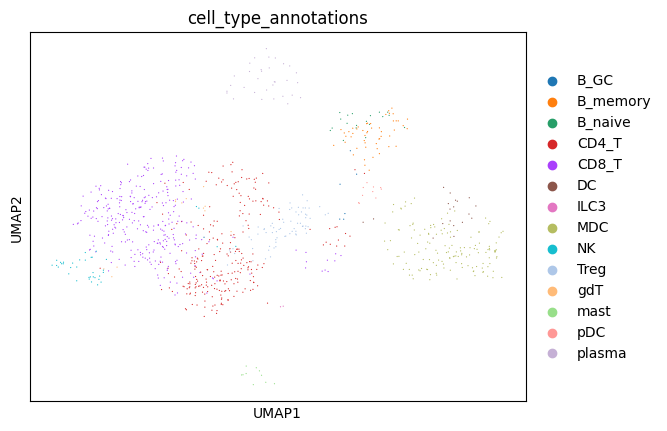

In [66]:
sc.pl.umap(adata, color = ['cell_type_annotations'], s = 3, 
           cmap='Spectral_r', legend_fontsize = 10, vmin=0)